<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_07_hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis testing from first principles

## Business question
Does issuing compensation improve 28-day retention, or could the observed difference be explained by random variation alone?

## Statistical question
How surprising would the observed data be if compensation had no effect?

## Define null world: Null Hypothesis (H0)

Issuing compensation has no effect on retention. Any observed difference is due to random variation.

The null is a data-generating world, not an opinion

In [1]:
# Simulate null world
import numpy as np

#Assume retention is the same regardless of compensation
n = 1000
true_retention_rate = 0.60

#simulate 2 groups under the null
ret_comp = np.random.binomial(1, true_retention_rate, n)
ret_no_comp = np.random.binomial(1, true_retention_rate, n)

observed_diff = ret_comp.mean() - ret_no_comp.mean()
observed_diff

# this is a fake universe where the null hypothesis is true

np.float64(0.0040000000000000036)

In [3]:
#repeat the null world many times

diffs = []

for _ in range(5000):
  ret_comp = np.random.binomial(1, true_retention_rate, n)
  ret_no_comp = np.random.binomial(1, true_retention_rate, n)
  diffs.append(ret_comp.mean() - ret_no_comp.mean())

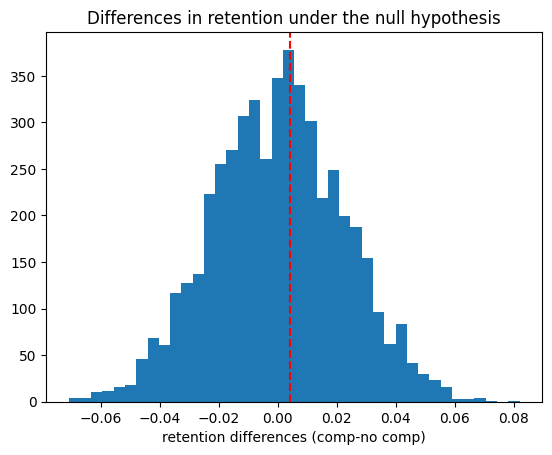

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(diffs, bins=40)
plt.axvline(observed_diff, color='red', linestyle='--')
plt.title('Differences in retention under the null hypothesis')
plt.xlabel("retention differences (comp-no comp)")
plt.show()

#most differences cluster around zero
#some differences are larger just by chance
#the question is: is what we observed rare in this null world?

## Mental model:

A hypothesis test asks:
"If the null hypothesis were true, how unsure would this data be?"
It does not ask "Is the null hypothesis true"